<a href="https://colab.research.google.com/github/praveenkumaresan/image-classification/blob/main/pk_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom CNN

In [7]:
import os
import shutil

# Path to the cache directory used by kagglehub
cache_directory = "/root/.cache/kagglehub"

# Check if the cache directory exists and delete it
if os.path.exists(cache_directory):
    shutil.rmtree(cache_directory)
    print("Cache cleared successfully.")
else:
    print("Cache directory not found.")


Cache cleared successfully.


In [8]:
import os
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Path to dataset files:", path)

# Function to print the directory structure
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        # for file in files:
        #     print(f"{sub_indent}{file}")

# Print the directory structure of the entire dataset
print("\nDirectory structure of the dataset:")
print_directory_structure(path)


100%|██████████| 242M/242M [00:01<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1

Directory structure of the dataset:
1/
    flower_images/
        Orchid/
        Lotus/
        Tulip/
        Sunflower/
        Lilly/


#### Split the dataset into test, training and validation

In [9]:
import os
import shutil
import random
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Path to dataset files:", path)

# Set the path to the flower_images directory
flower_images_dir = os.path.join(path, "flower_images")
base_dir = path

# Automatically create paths for train, validation, and test directories
train_directory = os.path.join(base_dir, "train")
validation_directory = os.path.join(base_dir, "validation")
test_directory = os.path.join(base_dir, "test")

# Create directories for training, validation, and test sets
os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Iterate over each class folder in flower_images
for class_name in os.listdir(flower_images_dir):
    class_dir = os.path.join(flower_images_dir, class_name)

    if os.path.isdir(class_dir):
        # Get a list of all image files in this class
        images = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)  # Shuffle the images randomly

        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * 0.7)
        validation_count = int(total_images * 0.2)

        # Create class directories in train, validation, and test folders
        os.makedirs(os.path.join(train_directory, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_directory, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_directory, class_name), exist_ok=True)

        # Split and copy images to the respective directories
        for i, image in enumerate(images):
            src_path = os.path.join(class_dir, image)
            if i < train_count:
                dest_path = os.path.join(train_directory, class_name, image)
            elif i < train_count + validation_count:
                dest_path = os.path.join(validation_directory, class_name, image)
            else:
                dest_path = os.path.join(test_directory, class_name, image)

            shutil.copy(src_path, dest_path)

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return count

# Print the number of images in each directory
print("\nNumber of images in each directory:")
print("Train Directory:", count_images_in_directory(train_directory))
print("Validation Directory:", count_images_in_directory(validation_directory))
print("Test Directory:", count_images_in_directory(test_directory))


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1

Number of images in each directory:
Train Directory: 3499
Validation Directory: 999
Test Directory: 501


#### Install necessary

In [10]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

#### Load and Preprocess the Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory = train_directory
print('train ', train_directory)
validation_directory = validation_directory
print('validation ', validation_directory)

# Create data generators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Data augmentation: rotate images
    width_shift_range=0.2,  # Data augmentation: shift images horizontally
    height_shift_range=0.2,  # Data augmentation: shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill strategy for augmented images
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical'  # Use 'binary' if you have only two classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


train  /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/train
validation  /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/validation
Found 3499 images belonging to 5 classes.
Found 999 images belonging to 5 classes.


###  v2.0 Define the CNN Model Architecture


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def build_custom_cnn(input_shape=(150, 150, 3), num_classes=5):
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    return model


### Compile the Model

In [27]:
# Build the model
model = build_custom_cnn()

# Compile the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Print the model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

###  Preprocess the Data
Use ImageDataGenerator for data preprocessing and augmentation. This ensures the model gets more diverse training examples.

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values to [0, 1]
    rotation_range=30,        # Random rotations
    width_shift_range=0.2,    # Horizontal shifts
    height_shift_range=0.2,   # Vertical shifts
    shear_range=0.2,          # Shearing transformations
    zoom_range=0.2,           # Zoom-in and zoom-out
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest'       # Fill missing pixels
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),   # Image size
    batch_size=32,
    class_mode='categorical'  # Multiclass classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 3499 images belonging to 5 classes.
Found 999 images belonging to 5 classes.


### Train the Model Train the CNN on the dataset:

In [36]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust based on performance
    validation_data=validation_generator
)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.5840 - loss: 1.0412 - precision: 0.7513 - recall: 0.3765 - val_accuracy: 0.6206 - val_loss: 0.9546 - val_precision: 0.7088 - val_recall: 0.4945
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6188 - loss: 0.9990 - precision: 0.7582 - recall: 0.4487 - val_accuracy: 0.6426 - val_loss: 0.9270 - val_precision: 0.7384 - val_recall: 0.4945
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6165 - loss: 0.9657 - precision: 0.7457 - recall: 0.4420 - val_accuracy: 0.6486 - val_loss: 0.8916 - val_precision: 0.7460 - val_recall: 0.5085
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.6381 - loss: 0.9244 - precision: 0.7785 - recall: 0.4748 - val_accuracy: 0.6416 - val_loss: 0.9044 - val_precision: 0.7760 - val_recall: 0.4855
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6624 - loss: 0.9208 - precision: 0.7885 - recall: 0.4718 - val_accuracy: 0.6346 - val_los

### Evaluate on the Test Set,  after training, evaluate the model on the test set:

In [37]:
# Load the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")



Found 501 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.6953 - loss: 0.7567 - precision: 0.7891 - recall: 0.5999
Test Loss: 0.7070
Test Accuracy: 71.46%
Test Precision: 80.10%
Test Recall: 62.67%


### Plot training and validation accuracy/loss:

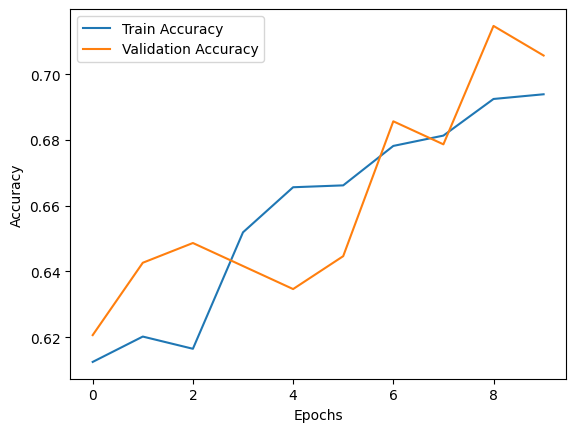

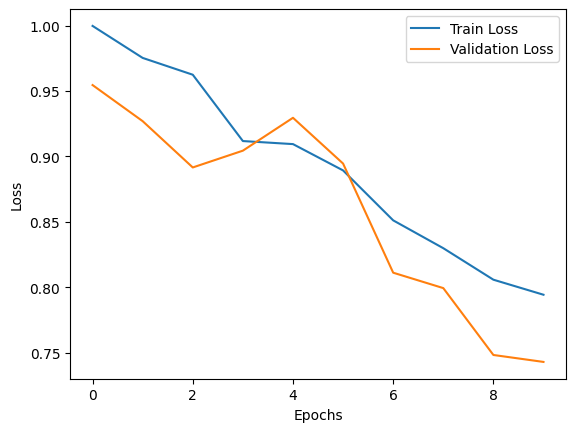

In [38]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Evaluate the Model with Confusion Matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step


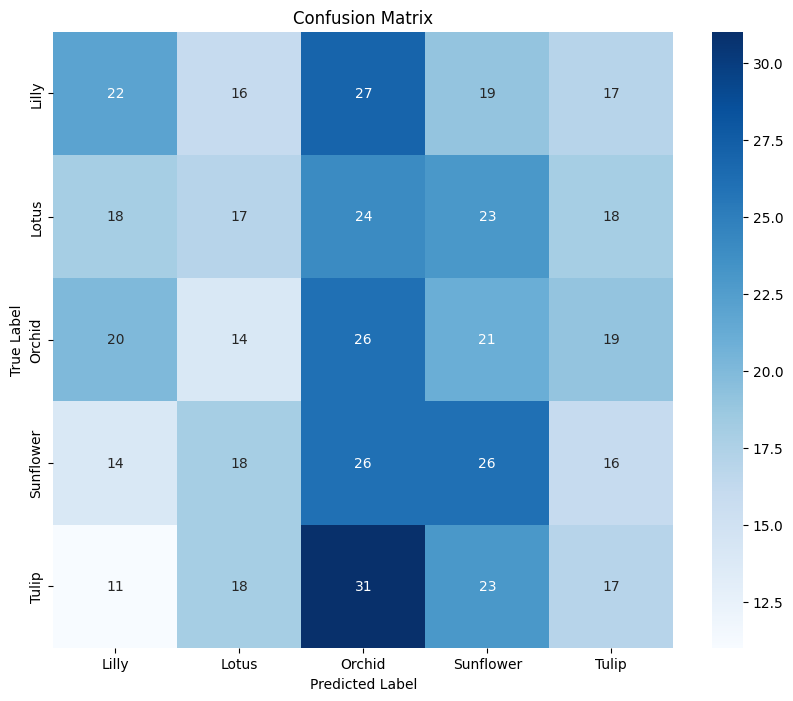

              precision    recall  f1-score   support

       Lilly       0.26      0.22      0.24       101
       Lotus       0.20      0.17      0.19       100
      Orchid       0.19      0.26      0.22       100
   Sunflower       0.23      0.26      0.25       100
       Tulip       0.20      0.17      0.18       100

    accuracy                           0.22       501
   macro avg       0.22      0.22      0.21       501
weighted avg       0.22      0.22      0.21       501



In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Visualizing Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


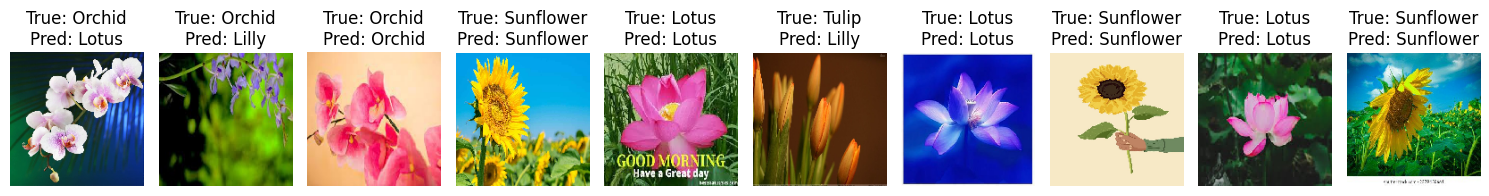

In [45]:
# Visualize predictions
def visualize_predictions(generator, num_images=10):
    class_labels = list(generator.class_indices.keys())
    batch = next(generator)
    images, labels = batch[0], batch[1]

    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on the test set
visualize_predictions(test_generator, num_images=10)
